In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import matplotlib.pyplot as plt

### Load LHC model from acc-models-lhc

In [3]:
# Load the sequence and the optics from the acc-model repository
lhc = xt.Multiline.from_json('acc-models-lhc/xsuite/lhc.json')
lhc.vars.load_madx("acc-models-lhc/strengths/ATS_Nominal/2024/ats_30cm.madx")

# Define reference particles
particle_ref = xt.Particles(energy0=6.8e12, mass0=xt.PROTON_MASS_EV)
lhc.b1.particle_ref = particle_ref
lhc.b2.particle_ref = particle_ref

# Cycle starting point to IP7
lhc.b1.cycle('ip7')
lhc.b2.cycle('ip7')

# Twiss default for B2 (use clockwise reference frame)
lhc.b2.twiss_default['reverse'] = True

Loading line from dict:   0%|          | 0/14477 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/14493 [00:00<?, ?it/s]

Done loading line from dict.           


### Switch off all orbit bumps

In [4]:
lhc['on_disp'] = 0.
lhc['on_xx1_v'] = 0.
lhc['on_x1_v'] = 0.
lhc['on_sep1_h'] = 0.
lhc['on_sep2h'] = 0.
lhc['on_x2v'] = 0.
lhc['on_xx5_h'] = 0.
lhc['on_x5_h'] = 0.
lhc['on_sep5_v'] = 0.
lhc['on_sep8h'] = 0.
lhc['on_x8v'] = 0.

### Twiss

In [5]:
twb1 = lhc.b1.twiss4d()
twb2 = lhc.b2.twiss4d()

In [6]:
# Tunes
twb1.qx, twb1.qy, twb2.qx, twb2.qy

(62.310000005043015, 60.31999999661716, 62.3100000046726, 60.320000000918576)

In [7]:
twb1.rows['ip.*'].cols['s betx bety']

TwissTable: 9 rows, 4 cols
name               s          betx          bety
ip7                0       120.813        149.43
ip8          3321.22             2             2
ip1.l1       6664.72           0.3           0.3
ip1          6664.72           0.3           0.3
ip2          9997.16            10            10
ip3          13329.4       121.567       218.585
ip4          16661.7       239.414       242.774
ip5            19994           0.3           0.3
ip6          23326.4       188.438       173.703

In [8]:
twb2.rows['ip.*'].cols['s betx bety']

TwissTable: 9 rows, 4 cols
name               s          betx          bety
ip8          3321.06             2             2
ip1.l1       6664.72           0.3           0.3
ip1          6664.72           0.3           0.3
ip2          9997.01            10            10
ip3          13329.4       121.567       218.584
ip4          16661.9       231.105       303.949
ip5          19994.3           0.3           0.3
ip6          23326.6       189.334       175.476
ip7          26658.9       120.813        149.43

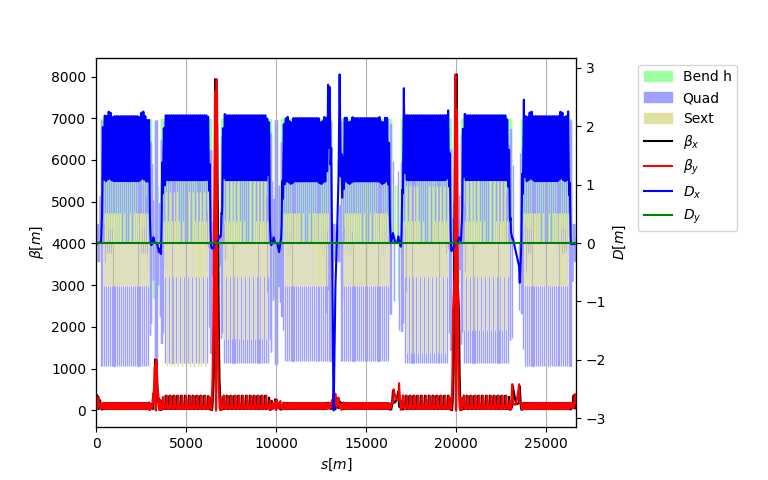

In [9]:
twb2.plot()

### Setup orbit bumps

In [10]:
lhc['on_disp'] = 1.
lhc['on_xx1_v'] = 160.0
lhc['on_x1_v'] = 160.0
lhc['on_sep1_h'] = 0.
lhc['on_sep2h'] = -1.0
lhc['on_x2v'] = 200.0
lhc['on_xx5_h'] = 160.0
lhc['on_x5_h'] = 160.0
lhc['on_sep5_v'] = 0.
lhc['on_sep8h'] = -1.0
lhc['on_x8v'] = 200.0

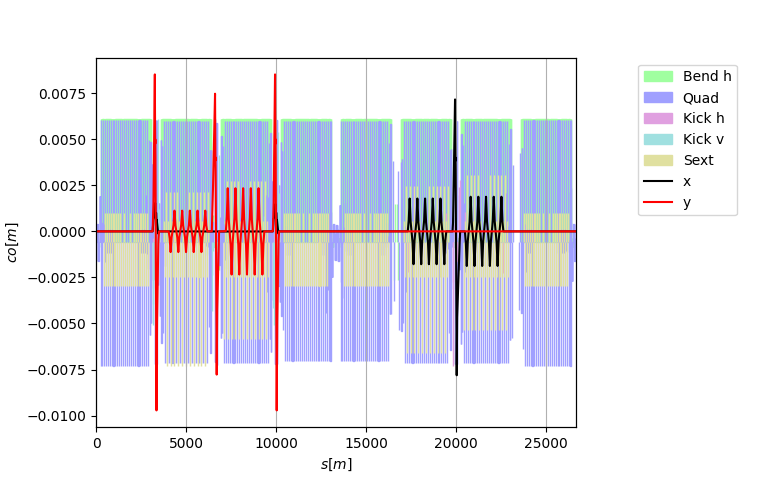

In [11]:
lhc.b2.twiss().plot('x y')

### Inspect circuits

In [12]:
lhc.info('kqx.r5', limit=None)

#  vars['kqx.r5']._get_value()
   vars['kqx.r5'] = 0.00877783444912

#  vars['kqx.r5']._expr
   vars['kqx.r5'] = (-vars['kqx.l5'])

#  vars['kqx.r5']._expr._get_dependencies()
   vars['kqx.l5'] = -0.00877783444912

#  vars['kqx.r5']._find_dependant_targets()
   eref['b2']['mqxb.b2r5'].k1
   eref['b2']['mqxb.a2r5'].k1
   eref['b2']['mqxa.3r5'].k1
   eref['b2']['mqxa.1r5'].k1
   eref['b1']['mqxb.a2r5'].k1
   eref['b1']['mqxb.b2r5'].k1
   eref['b1']['mqxa.3r5'].k1
   eref['b1']['mqxa.1r5'].k1



In [13]:
lhc.b1.info('mqxb.a2r5')

Element of type:  Quadrupole
k1                  -0.0087653179066814  (1.0 * ((-vars['kqx.r5']) - vars['ktqx2.r5']))
k1s                 0.0                  None                                          
length              5.5                  vars['l.mqxb']                                
num_multipole_kicks 0                    None                                          
order               5                    None                                          
inv_factorial_order 0.008333333333333333 None                                          
knl                 [0. 0. 0. 0. 0. 0.]  None                                          
ksl                 [0. 0. 0. 0. 0. 0.]  None                                          
edge_entry_active   0                    None                                          
edge_exit_active    0                    None                                          
_sin_rot_s          -999.0               None                                          
_co

### Match a knob to move b2 horizontally in IP1

We want to create a knob to control the horizontal position of beam 2 at IP1 (ATLAS experiment).

In [14]:
opt_b2 = lhc.b2.match_knob(
            run=False,
            knob_name='shift_h_ip1.b2',
            start='e.ds.l1.b2', end='s.ds.r1.b2',
            betx=1, bety=1, x=0, y=0, px=0, py=0, # <- initial conditions
            vary=xt.VaryList(['acbyh4.r1b2', 'acbch6.r1b2',
                              'acbyhs4.l1b2', 'acbch5.l1b2'],
                              step=1e-6),
            targets=[
                xt.TargetSet(x=1e-3, px=0, at='ip1'),
                xt.TargetSet(x=0, px=0, at=xt.END),
            ])
opt_b2.solve()
opt_b2.generate_knob()

                                             
Optimize - start penalty: 0.01          
Matching: model call n. 7               
Optimize - end penalty:  3.14737e-09
Generated knob:  shift_h_ip1.b2


In [15]:
# Test the knob
lhc['shift_h_ip1.b2'] = -2
lhc.b2.twiss4d()['x', 'ip1']

-0.0019999993370479092

In [16]:
lhc['shift_h_ip1.b2'] = 3
lhc.b2.twiss4d()['x', 'ip1']

0.003000000703958187

### Visualize orbit bump within the machine aperture

In [17]:
%%capture
from lhc_aperture_model import LhcApertureModel
aper_model = LhcApertureModel(lhc=lhc,
                aperture_file_path='APERTURE_EYETS 2023-2024.seq')

In [18]:
# Try to shift by 8 mm:
lhc['shift_h_ip1.b2'] = 8

Start twiss
Done twiss


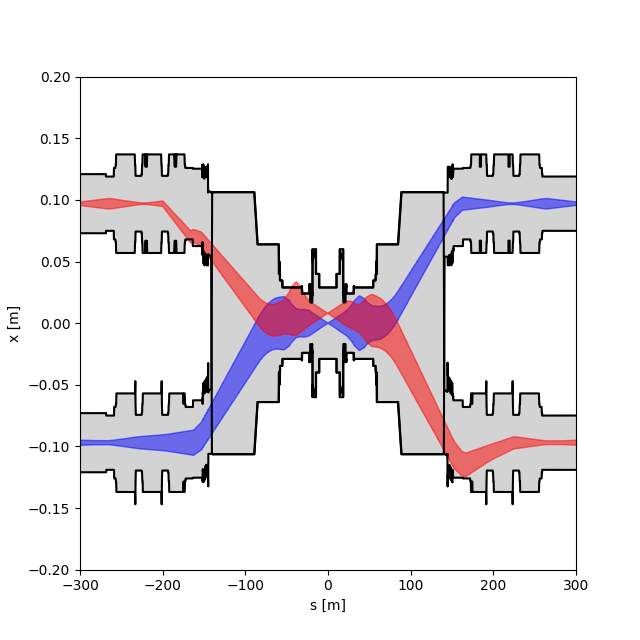

In [19]:
plt.figure(figsize=(6.4, 6.4))
aper_model.plot_horizontal_aperture_and_beam_envelopes(zero_at='ip1')
plt.xlim(-300, 300)
plt.ylim(-0.20, 0.20)
plt.show()

In [20]:
# Try a smaller shift (4 mm)
lhc['shift_h_ip1.b2'] = 4

Start twiss
Done twiss


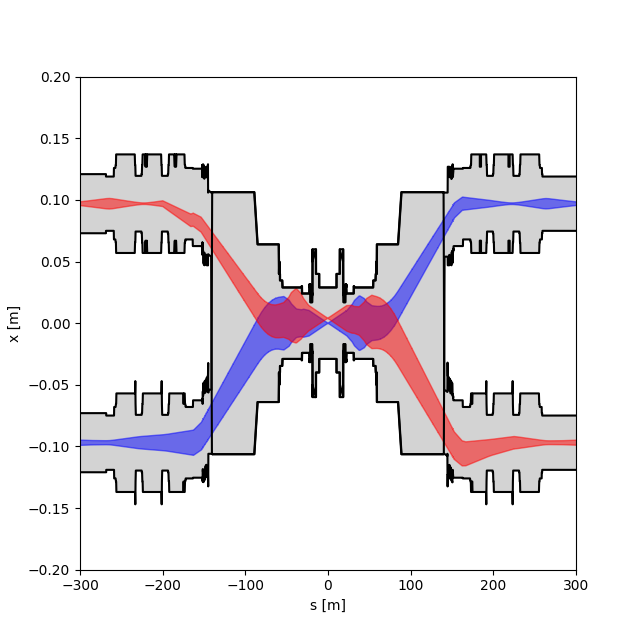

In [21]:
plt.figure(figsize=(6.4, 6.4))
aper_model.plot_horizontal_aperture_and_beam_envelopes(zero_at='ip1')
plt.xlim(-300, 300)
plt.ylim(-0.20, 0.20)
plt.show()

### Effect of the shift on the amplitude detuning from bb

In [22]:
# Install bb elements
lhc.install_beambeam_interactions(
    clockwise_line="b1",
    anticlockwise_line="b2",
    ip_names=["ip1", "ip2", "ip5", "ip8"],
    delay_at_ips_slots=[0, 891, 0, 2670],
    num_long_range_encounters_per_side={"ip1": 25, "ip2": 20, "ip5": 25, "ip8": 20},
    num_slices_head_on=11,
    harmonic_number=35640,
    bunch_spacing_buckets=10,
    sigmaz=0.076,
)
lhc.build_trackers()

Slicing line:   0%|          | 0/14477 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/14493 [00:00<?, ?it/s]

In [23]:
%%capture
# Compute tune footprint without the shift
lhc['shift_h_ip1.b2'] = 0

lhc.configure_beambeam_interactions(num_particles=1.8e11, nemitt_x=2.e-6,
                                    nemitt_y=2.e-6, crab_strong_beam=False)

fp_off = lhc.b1.get_footprint(
    freeze_longitudinal=True,
    nemitt_x=2.5e-6, nemitt_y=2.5e-6,
    linear_rescale_on_knobs=[
        xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.1)
    ],
)

In [24]:
%%capture
# Compute tune footprint without the shift
lhc['shift_h_ip1.b2'] = 4

lhc.configure_beambeam_interactions(num_particles=1.8e11, nemitt_x=2.e-6,
                                    nemitt_y=2.e-6, crab_strong_beam=False)

fp_on = lhc.b1.get_footprint(
    freeze_longitudinal=True,
    nemitt_x=2.5e-6, nemitt_y=2.5e-6,
    linear_rescale_on_knobs=[
        xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.1)
    ],
)

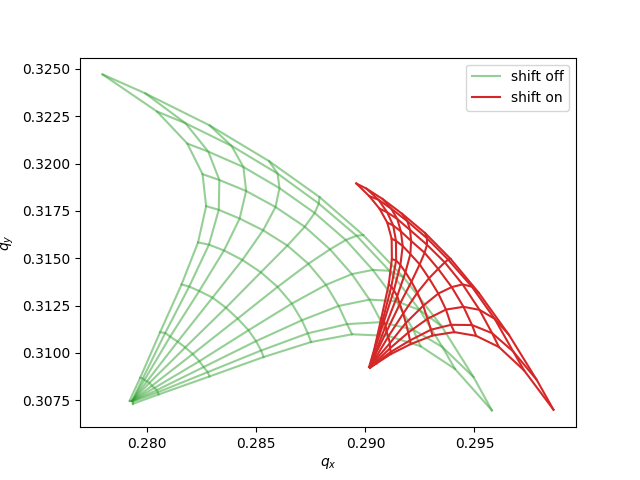

In [25]:
plt.figure()
fp_off.plot(color='C2', alpha=0.5, label='shift off')
fp_on.plot(color='C3', alpha=1, label='shift on')
plt.legend()

plt.show()